# System call Anomaly Detection- Deep Learning 

**ADFA Dataset Preprocessing:**

    1. The system call language model estimates the probability distribution of the next call in a sequence given the sequence of previous calls. 
       
    2. We assume that the host system generates a finite number of system calls. 
    
    3. We index each system call by using an integer starting from 1 and denote the fixed set of all possible system calls in the system as S = {1, · · · , K}. Let x = x1x2 · · · xl(xi ∈ S) denote a sequence of l system calls.
       
**LSTM Based Model :**     

    1. At the Input Layer, the call at each time step xi is fed into the model in the form of one-hot encoding,
       in other words, a K dimensional vector with all elements zero except position xi.
       
    2. At the Embedding Layer*, incoming calls are embedded to continuous space by multiplying embedding matrix W,
       which should be learned. 
       
    3. At the Hidden Layer*, the LSTM unit has an internal state, and this state is updated recurrently at each time step.
    
    4. At the Output Layer, a softmax activation function is used to produce the estimation of normalized probability values of possible calls coming next in the sequence.
    
**References for systemcalls:**
    1. http://osinside.net/syscall/system_call_table.htm
    2. https://www.cs.unm.edu/~immsec/systemcalls.htm    
    3. https://github.com/karpathy/char-rnn
    4. https://keras.io/losses/#categorical_crossentropy
    5. http://karpathy.github.io/2015/05/21/rnn-effectiveness/

# ADFA Dataset Preprocessing

In [1]:
# -*- coding: utf-8 -*-
"""
Created on Thu Aug  1 13:52:35 2019

@author: kuna
"""

#!/usr/bin/env python
# -*- coding: utf-8 -*-


import pickle
import sys

# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)
# ignore all user warnings
simplefilter(action='ignore', category=UserWarning)

def saveintopickle(obj, filename):
    with open(filename, 'wb') as handle:
        pickle.dump(obj, handle, protocol=pickle.HIGHEST_PROTOCOL)

    print ("[Pickle]: save object into {}".format(filename))
    return



def loadfrompickle(filename):
    with open(filename, 'rb') as handle:
        b = pickle.load(handle)
    return b



#draw the  process bar
def drawProgressBar(percent, barLen = 20):
    sys.stdout.write("\r")
    progress = ""
    for i in range(barLen):
        if i < int(barLen * percent):
            progress += "="
        else:
            progress += " "
    sys.stdout.write("[ %s ] %.2f%%" % (progress, percent * 100))
    sys.stdout.flush()

In [31]:
import numpy as np
#import io_helper


random_data_dup = 10  # each sample randomly duplicated between 0 and 9 times, see dropin function


def dropin(X, y):
    """
    The name suggests the inverse of dropout, i.e. adding more samples. See Data Augmentation section at
    http://simaaron.github.io/Estimating-rainfall-from-weather-radar-readings-using-recurrent-neural-networks/
    :param X: Each row is a training sequence
    :param y: Tne target we train and will later predict
    :return: new augmented X, y
    """
    print("X shape:", X.shape)
    print("y shape:", y.shape)
    X_hat = []
    y_hat = []
    for i in range(0, len(X)):
        for j in range(0, np.random.random_integers(0, random_data_dup)):
            X_hat.append(X[i, :])
            y_hat.append(y[i])
    return np.asarray(X_hat), np.asarray(y_hat)



def preprocess():

    arrayfile = "./array_test.pickle"
    array = loadfrompickle(arrayfile)
    #print(type(array))
    #print(array)
    x_train = array[:,:-1]
    y_train = array[:,-1]

    print ("The train data size is that ")
    print (x_train.shape)
    print (y_train.shape)
    return (x_train,y_train)

def preprocess_val():

    arrayfile = "./array_val.pickle"
    array = loadfrompickle(arrayfile)
    #print(type(array))
    #print(array)
    x_test = array[:,:-1]
    y_test = array[:,-1]

    print ("The train data size is that ")
    print (x_test.shape)
    print (y_test.shape)
    return (x_test,y_test)

#if __name__ =="__main__":
#   preprocess()

In [30]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-


import os
import sys
import numpy as np

#import io_helper

def readfilesfromAdir(dataset):
    #read a list of files
    files = os.listdir(dataset)
    files_absolute_paths = []
    for i in files:
        files_absolute_paths.append(dataset+str(i))
    return files_absolute_paths


file = "ADFA-LD/Training_Data_Master/UTD-0001.txt"
#this is used to read a char sequence from
def readCharsFromFile(file):
    channel_values = open(file).read().split()
    #print (len(channel_values))
    #channel_values is a list
    return channel_values
    #print (channel_values[800:819])

def get_attack_subdir(path):
    subdirectories = os.listdir(path)
    for i in range(0,len(subdirectories)):
        subdirectories[i] = path + subdirectories[i]

    print (subdirectories)
    return (subdirectories)


def get_all_call_sequences(dire):
    files = readfilesfromAdir(dire)
    allthelist = []
    print (len(files))

    for eachfile in files:
        if not eachfile.endswith("DS_Store"):
            allthelist.append(readCharsFromFile(eachfile))
        else:
            print ("Skip the file "+ str(eachfile))

    elements = []
    for item in allthelist:
        for key in item:
            if key not in elements:
                elements.append(key)

    elements = map(int,elements)
    elements = sorted(elements)

    print ("The total unique elements:")
    print (elements)

    print ("The maximum number of elements:")
    print (max(elements))

    #print ("The length elements:")
    #print (len(elements))
    print (len(allthelist))

    #clean the all list data set
    _max = 0
    for i in range(0,len(allthelist)):
        _max = max(_max,len(allthelist[i]))
        allthelist[i] = list(map(int,allthelist[i]))
        #print(allthelist[i])


    print ("The maximum length of a sequence is that {}".format(_max))

    return (allthelist)

## shift the data for analysis
def shift(seq, n):
    n = n % len(seq)
    return seq[n:] + seq[:n]


def convertToOneHot(vector, num_classes=None):
    """
    Converts an input 1-D vector of integers into an output
    2-D array of one-hot vectors, where an i'th input value
    of j will set a '1' in the i'th row, j'th column of the
    output array.

    Example:
        v = np.array((1, 0, 4))
        one_hot_v = convertToOneHot(v)
        print one_hot_v

        [[0 1 0 0 0]
         [1 0 0 0 0]
         [0 0 0 0 1]]
    """

    assert isinstance(vector, np.ndarray)
    assert len(vector) > 0

    if num_classes is None:
        num_classes = np.max(vector)+1
    else:
        assert num_classes > 0
        assert num_classes >= np.max(vector)

    result = np.zeros(shape=(len(vector), num_classes))
    result[np.arange(len(vector)), vector] = 1
    return result.astype(int)

"""
The num_class here is set as 341
"""

#one function do one thing
def sequence_n_gram_parsing(alist,n_gram=20,num_class=341):
    if len(alist) <= n_gram:
        return alist

    ans = []
    for i in range(0,len(alist)-n_gram+1,1):
        tmp = alist[i:i+n_gram]
        oneHot = convertToOneHot(np.asarray(tmp), num_class)
        ans.append(oneHot)

    #transform into nmup arrray
    ans = np.array(ans)
    return (ans)

def lists_of_list_into_big_matrix(allthelist,n_gram=20):

    array = sequence_n_gram_parsing(allthelist[0])

    for i in range(1,len(allthelist),1):
        tmp = sequence_n_gram_parsing(allthelist[i])

       # print ("tmp shape")
       # print (tmp.shape)

        array = np.concatenate((array, tmp), axis=0)


        percent = (i+0.0)/len(allthelist)
        #io_helper.drawProgressBar(percent)
        drawProgressBar(percent)

        if (len(array)> 20000):
            break
        #print ("array shape")
        #print (array.shape)


    print (array.shape)
    print ("done")
    #io_helper.saveintopickle(array,"array_test.pickle")
    saveintopickle(array,"array_test.pickle")


def lists_of_list_into_big_matrix_val(allthelist,n_gram=20):

    array = sequence_n_gram_parsing(allthelist[0])

    for i in range(1,len(allthelist),1):
        tmp = sequence_n_gram_parsing(allthelist[i])

       # print ("tmp shape")
       # print (tmp.shape)

        array = np.concatenate((array, tmp), axis=0)


        percent = (i+0.0)/len(allthelist)
        #io_helper.drawProgressBar(percent)
        drawProgressBar(percent)

        if (len(array)> 20000):
            break
        #print ("array shape")
        #print (array.shape)


    print (array.shape)
    print ("done")
    #io_helper.saveintopickle(array,"array_test.pickle")
    saveintopickle(array,"array_val.pickle")

if __name__ == "__main__":
    dirc = "ADFA-LD/Training_Data_Master/"
    dirc_val = "ADFA-LD/Validation_Data_Master/"
    dic_attack ="ADFA-LD/Attack_Data_Master/"
    #train1 = get_all_call_sequences(dirc)

    #test = [i for i in range(0,300)]
    #array = sequence_n_gram_parsing(test)
    #print (type(array))
    #print (array.shape)

    #get_attack_subdir(dic_attack)
    #print ("XxxxxxxXXXXXXXXXXX")
    #val1 = get_all_call_sequences(dirc_val)
    att = get_all_call_sequences(dirc)
    lists_of_list_into_big_matrix(att)
    att_val = get_all_call_sequences(dirc_val)
    lists_of_list_into_big_matrix_val(att_val)


834
Skip the file ADFA-LD/Training_Data_Master/.DS_Store
The total unique elements:
[1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 19, 20, 21, 26, 27, 30, 33, 37, 38, 39, 40, 41, 42, 43, 45, 54, 57, 60, 63, 64, 65, 66, 75, 77, 78, 83, 85, 91, 93, 94, 96, 97, 99, 102, 104, 110, 114, 117, 118, 119, 120, 122, 125, 128, 132, 133, 140, 141, 142, 143, 144, 146, 148, 155, 157, 158, 159, 160, 162, 163, 168, 172, 174, 175, 176, 179, 180, 183, 184, 185, 191, 192, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 211, 212, 213, 214, 219, 220, 221, 224, 226, 228, 229, 230, 231, 233, 234, 240, 242, 243, 252, 254, 255, 256, 258, 259, 260, 264, 265, 266, 268, 269, 270, 272, 289, 292, 293, 295, 298, 300, 301, 307, 308, 309, 311, 314, 320, 322, 331, 332, 340]
The maximum number of elements:
340
833
The maximum length of a sequence is that 2948
[ =                    ] 8.52%(20298, 20, 341)
done
[Pickle]: save object into array_test.pickle
4373
Skip the file ADFA-LD/Validatio

# LSTM Based Model

In [15]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

import matplotlib.pyplot as plt
import numpy as np
import time
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from keras.models import model_from_json


#import preprocess

# Global hyper-parameters
sequence_length = 19
epochs = 1
batch_size = 50
feature_dimension = 341


def save_model_weight_into_file(model, modelname="model.json", weight="model.h5"):
    model_json = model.to_json()
    with open(modelname, "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    model.save_weights(weight)
    print("Saved model to disk in {} and {}".format(modelname,weight))


def load_model_and_wieght_from_file(modelname="model.json", weight="model.h5"):

    json_file = open(modelname, 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    # load weights into new model
    loaded_model.load_weights(weight)
    print("Loaded model from disk, you can do more analysis more")

    pass

def build_model():
    model = Sequential()
    layers = {'input': feature_dimension, 'hidden1': 64, 'hidden2': 256, 'hidden3': 100, 'output': feature_dimension}

    model.add(LSTM(
            input_length=sequence_length,
            input_dim=layers['input'],
            output_dim=layers['hidden1'],
            return_sequences=True))
    model.add(Dropout(0.2))

    model.add(LSTM(
            layers['hidden2'],
            return_sequences=True))
    model.add(Dropout(0.2))

    model.add(LSTM(
            layers['hidden3'],
            return_sequences=False))
    model.add(Dropout(0.2))

    model.add(Dense(
            output_dim=layers['output'],activation='softmax'))
    #model.add(Activation("linear"))

    start = time.time()

    model.compile(loss="categorical_crossentropy", optimizer='rmsprop',  metrics=['accuracy'])
    #model.compile(loss="mse", optimizer="rmsprop")

    #print ("Compilation Time : "%(time.time() - start))
    return model

from keras.callbacks import EarlyStopping

def run_network(model=None, data=None):

    global_start_time = time.time()
    
    if data is None:
        print ('Loading data... ')
        # train on first 700 samples and test on next 300 samples (has anomaly)
        X_train, y_train  = preprocess()
    else:
        X_train, y_train = data

    print ("X_train, y_train,shape")
    print (X_train.shape)
    print (y_train.shape)
    print ('\nData Loaded. Compiling...\n')

    if model is None:
        model = build_model()
        print("Training...")
        model.fit(
                X_train, y_train,
                batch_size=batch_size,
                epochs=epochs,
                validation_split=0.05)
        model.summary()
        print("Done Training...")

    #predicted = model.predict(X_test)
    #print("Reshaping predicted")
    #predicted = np.reshape(predicted, (predicted.size,))



   
    """
    except KeyboardInterrupt:
        print("prediction exception")
        print 'Training duration (s) : ', time.time() - global_start_time
        return model, y_test, 0
   
    try:
        plt.figure(1)
        plt.subplot(311)
        plt.title("Actual Test Signal w/Anomalies")
        plt.plot(y_test[:len(y_test)], 'b')
        plt.subplot(312)
        plt.title("Predicted Signal")
        plt.plot(predicted[:len(y_test)], 'g')
        plt.subplot(313)
        plt.title("Squared Error")
        mse = ((y_test - predicted) ** 2)
        plt.plot(mse, 'r')
        plt.show()
    except Exception as e:
        print("plotting exception")
        print (str(e))
    print ('Training duration (s) : '% (time.time() - global_start_time))

    return model, y_test, predicted
   """

#if __name__ == "__main__":
# run_network()    

In [ ]:
df= pd.read_pickle

## Train LSTM Model

In [36]:
global_start_time = time.time()
    
model=None

print ('Loading data... ')
# train on first 700 samples and test on next 300 samples (has anomaly)
X_train, y_train  = preprocess()

print ("X_train, y_train,shape")
print (X_train.shape)
print (y_train.shape)
print ('\nData Loaded. Compiling...\n')

if model is None:
    model = build_model()
    print("Training...")
    history = model.fit(
            X_train, y_train,
            batch_size=batch_size,
            epochs=epochs,
            validation_split=0.05,
            callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])
    model.summary()
    print("Done Training...")


Loading data... 
The train data size is that 
(20298, 19, 341)
(20298, 341)
X_train, y_train,shape
(20298, 19, 341)
(20298, 341)

Data Loaded. Compiling...

Training...
Train on 19283 samples, validate on 1015 samples
Epoch 1/1
19283/19283 [==============================] - 31s 2ms/step - loss: 2.7311 - acc: 0.2456 - val_loss: 2.2571 - val_acc: 0.2808
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_25 (LSTM)               (None, 19, 64)            103936    
_________________________________________________________________
dropout_25 (Dropout)         (None, 19, 64)            0         
_________________________________________________________________
lstm_26 (LSTM)               (None, 19, 256)           328704    
_________________________________________________________________
dropout_26 (Dropout)         (None, 19, 256)           0         
____________________________________________________

In [58]:
#import pandas as pd

#def loadData(file): 
    # for reading also binary mode is important 
#    dbfile = open(file, 'rb')      
#    db = pickle.load(dbfile) 
#    for keys in db: 
#        print(keys, '=>', db[keys]) 
#    dbfile.close() 
  
#if __name__ == '__main__': 
#    loadData("./array_test.pickle") 
#df_val = pd.read_pickle("./array_val.pickle")
#df_val.head()

## Run model on Validation Data

In [46]:
# https://towardsdatascience.com/multi-class-text-classification-with-lstm-1590bee1bd17

X_test, y_test = preprocess_val()

print ("X_test, y_test,shape")
print (X_test.shape)
print (y_test.shape)

print("Validating...")
predicted = model.predict(X_test)
print("Done Validating...")
print(predicted)


The train data size is that 
(21238, 19, 341)
(21238, 341)
X_test, y_test,shape
(21238, 19, 341)
(21238, 341)
Validating...
Done Validating...
[[5.03549074e-07 5.11274324e-04 1.90999685e-06 ... 6.67329573e-07
  7.41592942e-07 6.66175220e-06]
 [8.51366792e-07 5.51261590e-04 3.50256823e-06 ... 1.30128683e-06
  1.29121929e-06 1.07382693e-05]
 [4.46622835e-07 5.26654825e-04 1.81123414e-06 ... 6.48105015e-07
  7.11315522e-07 6.07781658e-06]
 ...
 [2.37265867e-05 2.50867661e-03 2.65557974e-05 ... 2.01402763e-05
  1.91918843e-05 1.12194786e-04]
 [2.39555939e-05 2.51514651e-03 2.68349286e-05 ... 2.03429117e-05
  1.94765016e-05 1.12630878e-04]
 [2.04245025e-05 2.35214341e-03 2.36305568e-05 ... 1.74006982e-05
  1.64858102e-05 9.88534739e-05]]


## How did our model perform?

In [51]:

score, accuracy = model.evaluate(X_test, y_test, verbose=2, batch_size=batch_size)
print('Score : %.2f'%(score))
print('Validation Accuracy : %.2f'%(accuracy))

Score : 2.64
Validation Accuracy : 0.37


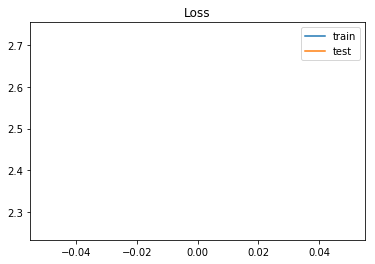

In [52]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

In [53]:
history.history

{'val_loss': [2.2570636331154206],
 'val_acc': [0.28078817759681807],
 'loss': [2.7311162518705685],
 'acc': [0.2456049372040279]}

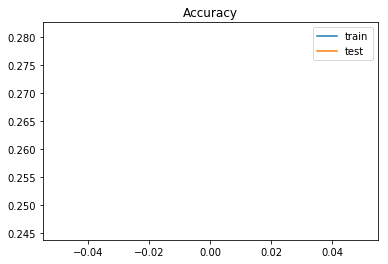

In [54]:

plt.title('Accuracy')
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='test')
plt.legend()
plt.show();

## How to Test with new systemcall  sequence ??